In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfd = tfp.distributions

2023-10-06 09:09:02.063721: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 09:09:02.657668: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-06 09:09:02.657727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-06 09:09:02.661590: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-06 09:09:02.975272: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-06 09:09:02.980852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
file = 'outputs/pred_matchday_7.xlsx'

In [3]:
db = pd.read_excel(file, index_col = 0)   

In [4]:
db

,role,team,oppteam,home,starter,vote%,MV,MV std,FV,FV std,MV loc,MV scale,MV skewness,MV tailweight,FV loc,FV scale,FV skewness,FV tailweight,Clean Sheet %
player,,,,,,,,,,,,,,,,,,,
Carnesecchi,P,Atalanta,Juventus,1,0.0,5,6.140590,0.481707,5.070139,0.715923,5.980216,0.509892,0.230396,1.086084,5.321455,1.055452,-0.174796,0.965320,20.727640
Musso,P,Atalanta,Juventus,1,1.0,70,6.171150,0.480294,5.038867,0.684976,5.986030,0.494852,0.272883,1.084060,5.255883,1.019420,-0.156479,0.983446,28.833491
Rossi F.,P,Atalanta,Juventus,1,0.0,1,6.170296,0.480470,5.037872,0.684438,5.984473,0.494652,0.273999,1.084374,5.254371,1.018776,-0.156209,0.983780,28.943959
Zappacosta,D,Atalanta,Juventus,1,1.0,90,5.985259,0.522062,6.206951,0.733274,6.001576,0.613546,-0.019559,0.881605,5.760596,1.050439,0.307981,1.299815,0.000000
Toloi,D,Atalanta,Juventus,1,1.0,90,6.002894,0.499877,6.196084,0.699952,6.035264,0.591494,-0.040256,0.892304,5.804792,1.025037,0.278035,1.299814,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Henry,A,Verona,Torino,0,0.4,60,5.839920,0.444240,6.116677,0.669289,5.631952,0.453545,0.332464,0.906913,5.474079,0.755754,0.577176,1.299852,0.000000
Djuric,A,Verona,Torino,0,0.0,0,5.988754,0.256611,6.065000,0.293257,6.035156,0.320372,-0.107045,1.115607,5.977599,0.469125,0.137929,1.299758,0.000000
Kallon,A,Verona,Torino,0,0.0,0,5.863674,0.392202,6.044829,0.522801,5.719528,0.414042,0.254175,0.962003,5.592772,0.641898,0.490306,1.299833,0.000000


In [5]:
def get_player_distributions(player): 
    dist_mv = tfp.distributions.SinhArcsinh(
    db.loc[player, 'MV loc'],
    db.loc[player, 'MV scale'],
    db.loc[player, 'MV skewness'],
    db.loc[player, 'MV tailweight']
    )
    
    dist_fv = tfp.distributions.SinhArcsinh(
    db.loc[player, 'FV loc'],
    db.loc[player, 'FV scale'],
    db.loc[player, 'FV skewness'],
    db.loc[player, 'FV tailweight']
    )
    
    dist_cs = tfp.distributions.Bernoulli(probs = db.loc[player, 'Clean Sheet %']/100)
    
    return [dist_mv, dist_fv, dist_cs];

In [35]:
def simulate_lineup(squad, ITERS = 1000, MOD = False, mod_points_dict = None, CS = False, plot = True):
    dist = [None] * len(squad)

    defenders = list([0]) * len(squad)

    if mod_points_dict is None:
        mod_points_dict = {"high": 3, "medium": 2, "low": 1}

    for i in range(len(squad)):
        dist[i] = get_player_distributions(squad[i])  

        if(db['role'][squad[i]] == 'D'):
            defenders[i] = 1
            
    total_points = np.zeros(ITERS)
    clean_sheets = np.zeros(ITERS)
    mod_points = np.zeros(ITERS)

    mv_samples = [None] * len(squad)
    fv_samples = [None] * len(squad)

    for i in range(len(squad)):
        mv_samples[i] = dist[i][0].sample(ITERS)
        fv_samples[i] = dist[i][1].sample(ITERS)

    cs_samples = dist[0][2].sample(ITERS)

    for k in range(ITERS):
        d_points = list([0]) * len(squad)

        cleansheet = float(cs_samples[k])
        if(not CS):
            cleansheet = 0;
            
        total_points[k] += cleansheet
        clean_sheets[k] += cleansheet

        for i in range(len(squad)):
            if(db['role'][squad[i]] == 'P'):
                gk_points = float(mv_samples[i][k])

            if(defenders[i] == 1):
                d_points[i] = float(mv_samples[i][k])

            total_points[k] += float(fv_samples[i][k])

        d_points.sort(reverse = True)

        if(MOD and d_points[3] > 0): # minimum 3 defenders to get MOD
            mod_avg = 0
            for j in range(3):
                mod_avg += round(d_points[j] * 2) / 2
            mod_avg += round(gk_points * 2) / 2
            mod_avg /= 4

            if(mod_avg >= 7):
                mod_points[k] = mod_points_dict['high']
            elif(mod_avg >= 6.5):
                mod_points[k] = mod_points_dict['medium']
            elif(mod_avg >= 6):
                mod_points[k] = mod_points_dict['low']

        total_points[k] += mod_points[k]
    
    loc_0 = total_points.mean()

    squad_model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(3),
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.SinhArcsinh(loc= loc_0 + t[..., 0], scale = 1e-3 + tf.math.softplus(t[..., 1]), 
                                                        skewness = t[..., 2], tailweight = 0.8) # fixed tailweight seems ok
            )
        ]
    )

    def negloglik(y, distr):
        return -distr.log_prob(y)

    squad_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1), loss=negloglik)

    dummy_input = np.zeros(total_points.shape)[:, np.newaxis]
    squad_model.fit(dummy_input, total_points, epochs=100, verbose=False)
    
    squad_points_dist = squad_model(np.zeros(1)[:, np.newaxis])

    if(plot):

        x = np.arange(start = 0, stop = 200, step = 0.001)
        prb = squad_points_dist.prob(x)

        mn = total_points.mean()
        pot = mn + 2 * total_points.std()

        f, ax = plt.subplots(1, 2)

        ax[0].plot(x, prb)
        ax[0].fill_between(x, prb, color = 'lightblue')
        ax[0].vlines(x = mn, color = 'black', ymin = 0, ymax = 3, linestyle = 'dashed', label = 'mean = ' + "{:.2f}".format(mn))
        ax[0].vlines(x = pot, color = 'grey', ymin = 0, ymax = 3, linestyle = 'dashed', label = 'potential = ' + "{:.2f}".format(pot))

        
        ax[0].set_xlim([40, 140])
        ax[0].set_ylim([0, 0.12])

        ax[0].legend()

        #ax[0].hist(total_points, bins = 20, density = True)


        ax[1].text(0.1, 0.8, "\n".join(squad), fontsize=10, transform=ax[1].transAxes, verticalalignment = 'top')

        text = "\n".join(['Avg Total Points = ' + "{:.2f}".format(total_points.mean()), 
                          'Avg Mod Points = ' + "{:.2f}".format(mod_points.mean()), 
                          'Avg Clean Sheets = ' + "{:.2f}".format(clean_sheets.mean())])

        ax[1].text(0.5, 0.8, text, fontsize=10, transform=ax[1].transAxes, verticalalignment = 'top')

        ax[1].axis('off')



        plt.subplots_adjust(right=1.5)

        plt.show()
    return [squad_model, squad_points_dist, total_points.mean(), mod_points.mean(), clean_sheets.mean()]

In [36]:
def sinh_archsinh_pdf(x, mu, sigma, eps, delta):
    mul = 2 / np.sinh( np.arcsinh(2) * delta)    
    z = (x - mu) / (sigma*mul)            
    S = np.sinh( -eps + (1/delta) * np.arcsinh(z))
    return np.exp(-0.5 * S * S) * np.sqrt(1 + S * S) / ( sigma * mul * delta ) / np.sqrt(1 + z * z) / np.sqrt(2 * np.pi)

def plot_lineup(squad, config):
    fig, axs = plt.subplots(6, 5, figsize=(14, 10))

    i = 0;
    j = 1;

    for ax in axs.flat:
        ax.axis('off')

        if(i < len(config) and config[i] == j):
            player = squad[i];

            mu = db.loc[player, 'FV loc'];
            sigma = db.loc[player, 'FV scale'];
            eps = db.loc[player, 'FV skewness'];
            delta = db.loc[player, 'FV tailweight'];

            x = np.arange(start = 0, stop = 30, step = 0.001)

            pxf = sinh_archsinh_pdf(x, mu, sigma, eps, delta)

            mf = np.average(x, weights = pxf);


            ax.plot(x, pxf, color = 'g', label = player)
            ax.fill_between(x, pxf, color = 'lightgreen')

            ax.vlines(x = mf, color = 'g', ymin = 0, ymax = 3, linestyle = 'dashed', label = 'mfv = ' + '{:.2f}'.format(mf))    

            ax.legend(fontsize="9", loc ="upper right", handletextpad=0, handlelength=0)

            ax.axis(xmin = 0, xmax = 15, ymin = 0, ymax = 1)

            ax.axis('on')
            ax.get_yaxis().set_visible(False)

            ax.tick_params(axis='both', labelsize=7)

            i = i + 1;

        j = j + 1;
    


In [37]:
config_442 = [3, 6, 7, 9, 10, 15, 17, 19, 21, 27, 29];
config_433 = [3, 6, 7, 9, 10, 13, 17, 19, 26, 28, 30];
config_343 = [3, 7, 8, 9, 11, 15, 17, 19, 26, 28, 30];
config_4231 = [3, 6, 7, 9, 10, 12, 19, 23, 25, 26, 28];
config_433_classic = [3, 6, 7, 9, 10, 17, 18, 19, 26, 28, 30];
config_343_classic = [3, 7, 8, 9, 16, 17, 19, 20, 26, 28, 30];

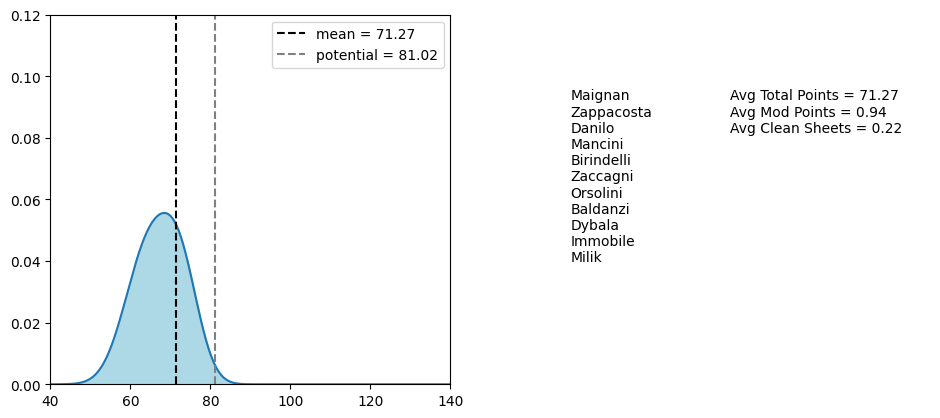

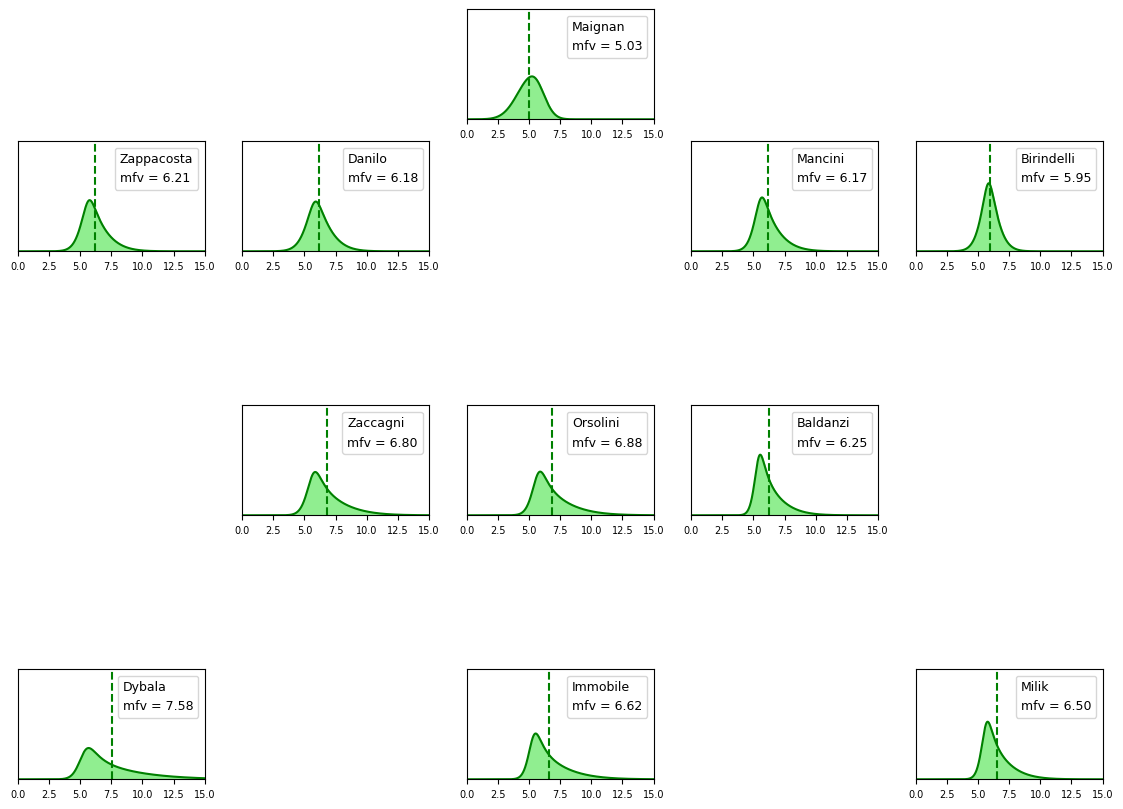

In [38]:
squad = ['Maignan',
        'Zappacosta',
        'Danilo',
        'Mancini',
        'Birindelli',
        'Zaccagni',
        'Orsolini',
        'Baldanzi',
        'Dybala',
        'Immobile',
        'Milik']

s = simulate_lineup(squad, MOD = True, CS = True)

plot_lineup(squad, config_433_classic)

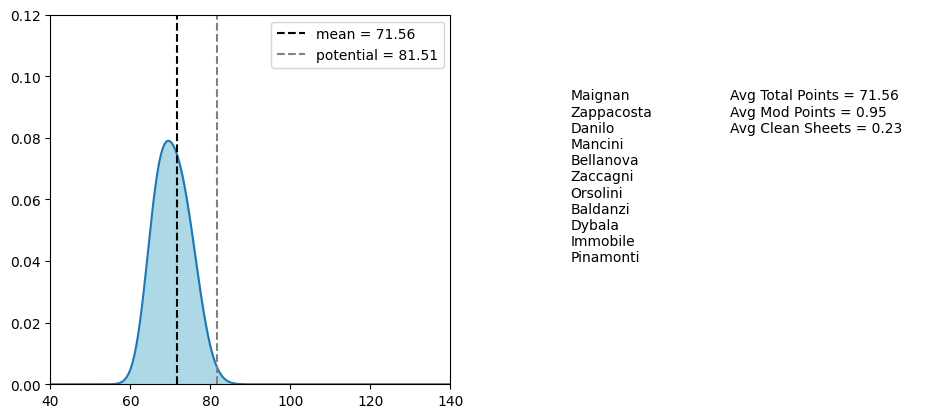

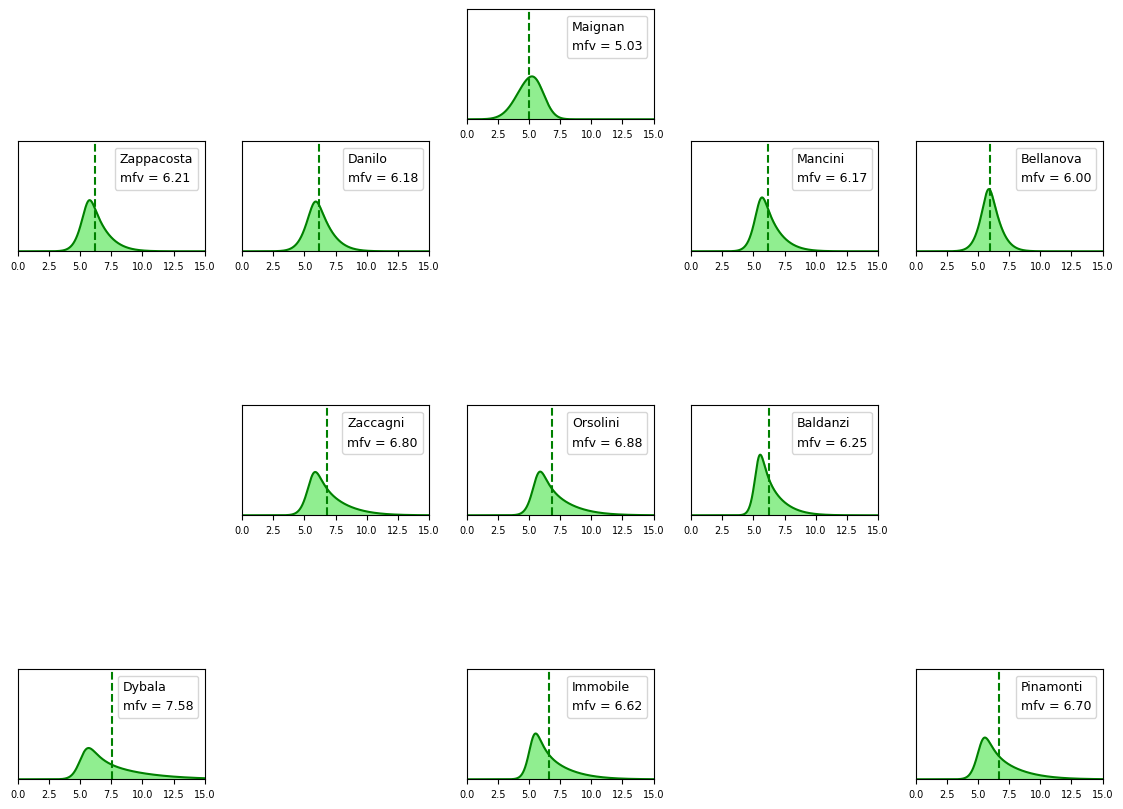

In [39]:
squad = ['Maignan',
        'Zappacosta',
        'Danilo',
        'Mancini',
        'Bellanova',
        'Zaccagni',
        'Orsolini',
        'Baldanzi',
        'Dybala',
        'Immobile',
        'Pinamonti']

s = simulate_lineup(squad, MOD = True, CS = True)

plot_lineup(squad, config_433_classic)

In [ ]:
squad = ['Skorupski',
        'Zappacosta',
        'Danilo',
        'Mancini',
        'Bellanova',
        'Zaccagni',
        'Orsolini',
        'Baldanzi',
        'Dybala',
        'Immobile',
        'Pinamonti']

s = simulate_lineup(squad, MOD = True, CS = True)

plot_lineup(squad, config_433_classic)

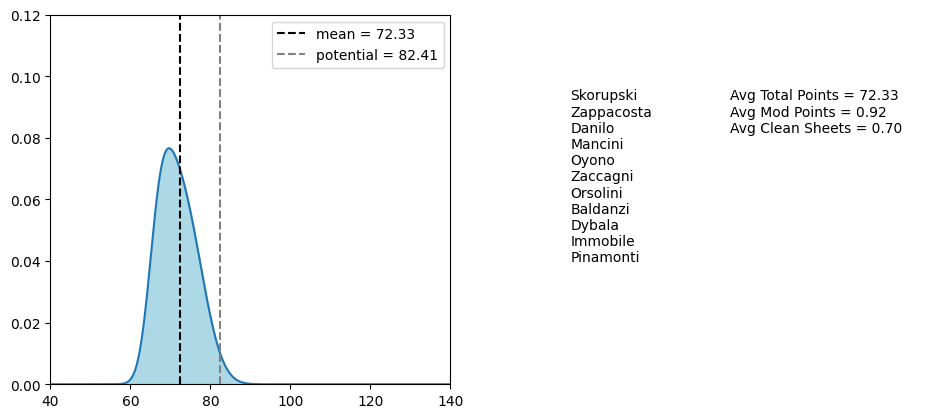

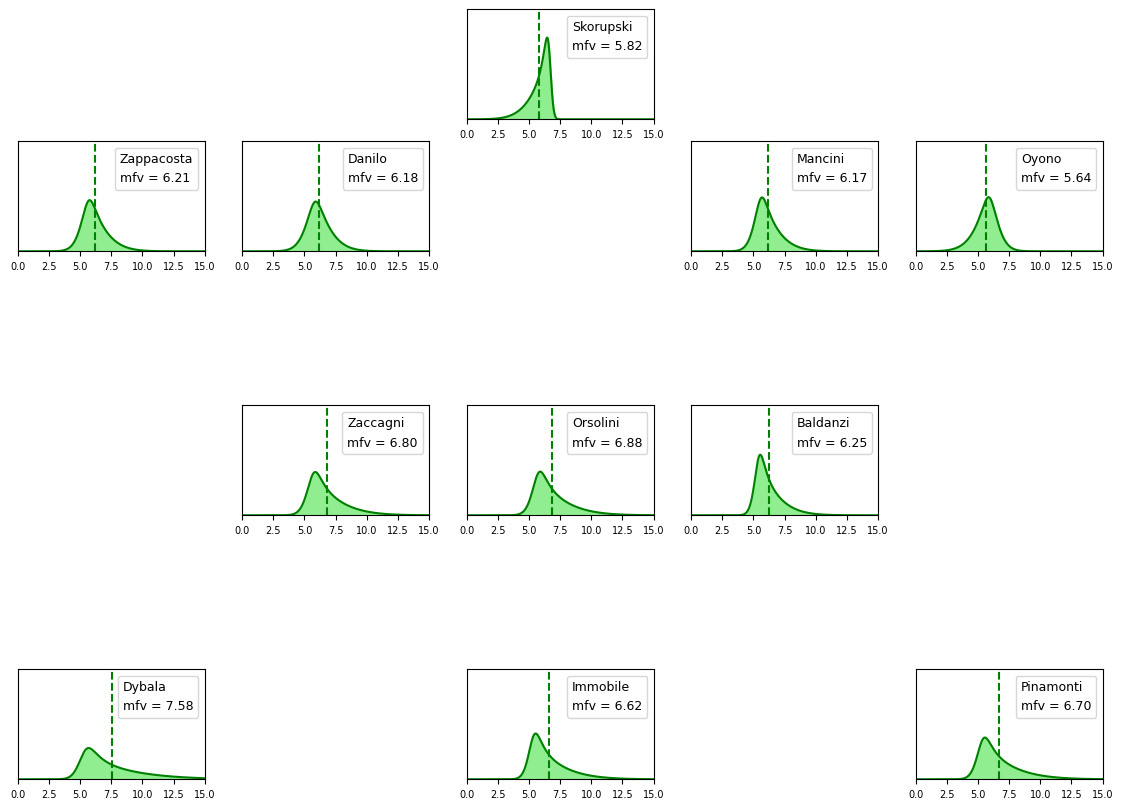

In [ ]:
squad = ['Skorupski',
        'Zappacosta',
        'Danilo',
        'Mancini',
        'Oyono',
        'Zaccagni',
        'Orsolini',
        'Baldanzi',
        'Dybala',
        'Immobile',
        'Pinamonti']

s = simulate_lineup(squad, MOD = True, CS = True)

plot_lineup(squad, config_433_classic)

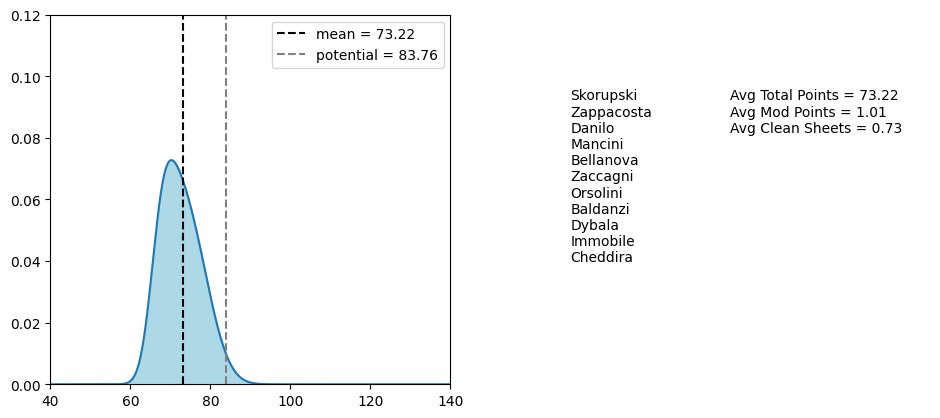

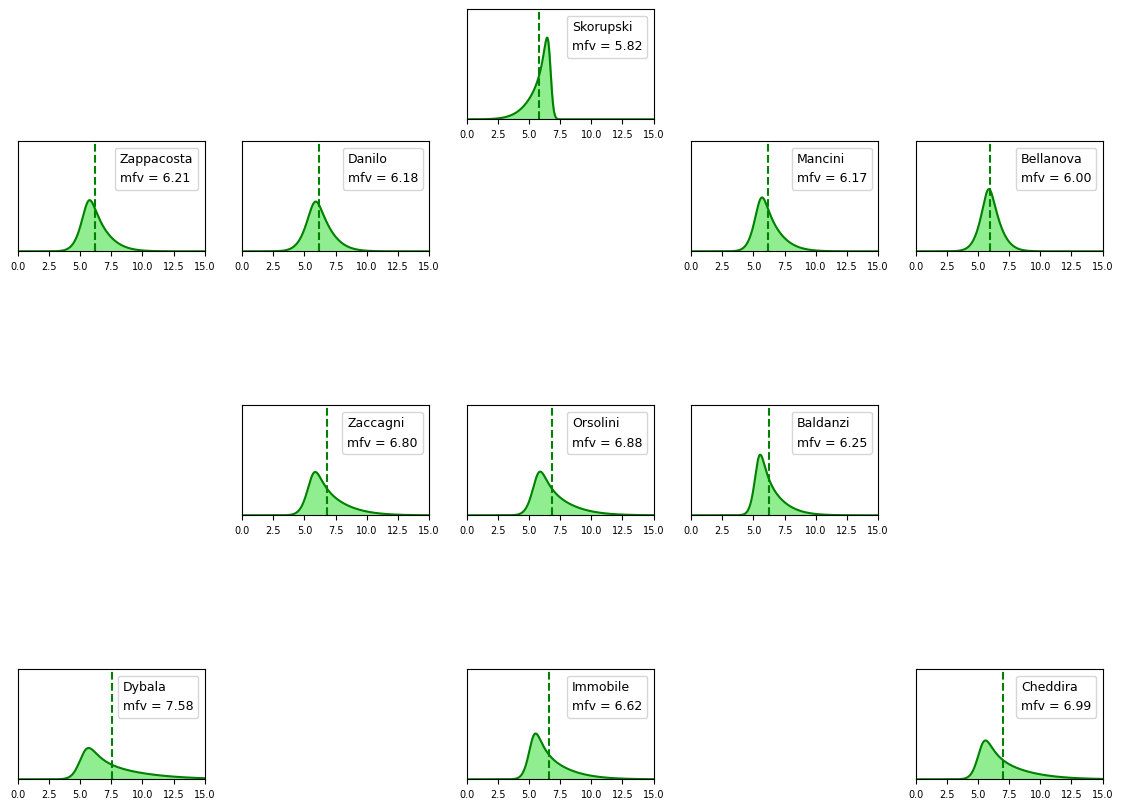

In [ ]:
squad = ['Skorupski',
        'Zappacosta',
        'Danilo',
        'Mancini',
        'Bellanova',
        'Zaccagni',
        'Orsolini',
        'Baldanzi',
        'Dybala',
        'Immobile',
        'Cheddira']

s = simulate_lineup(squad, MOD = True, CS = True)

plot_lineup(squad, config_433_classic)

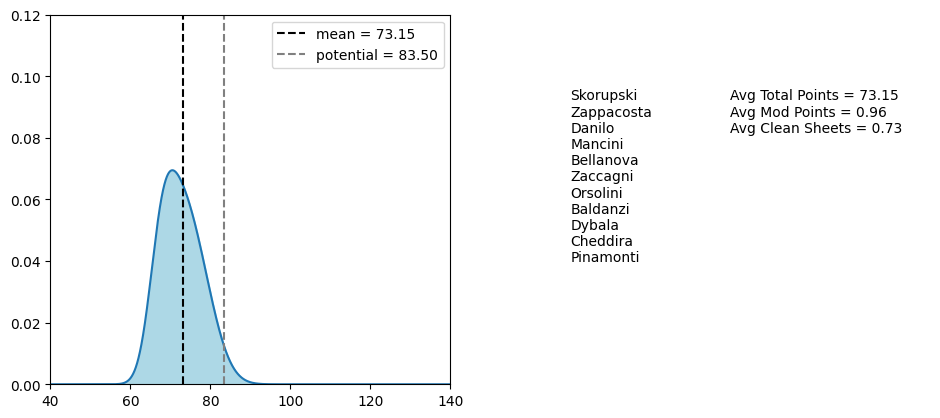

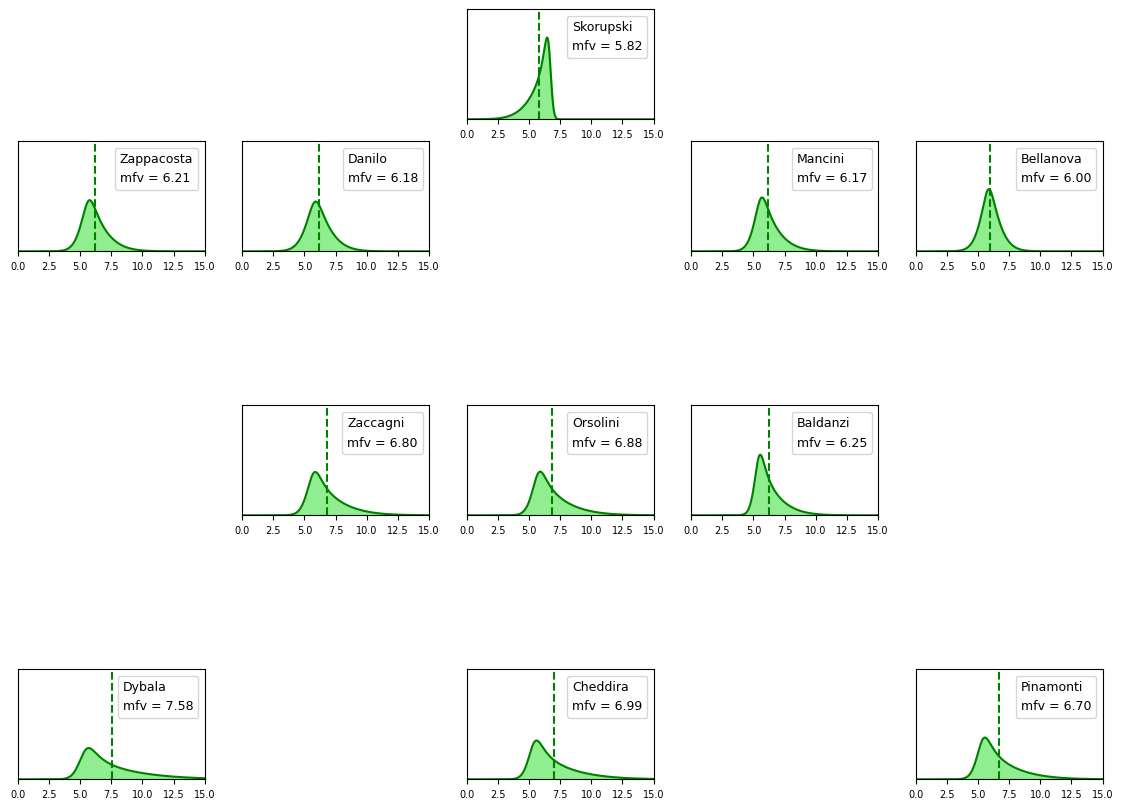

In [ ]:
squad = ['Skorupski',
        'Zappacosta',
        'Danilo',
        'Mancini',
        'Bellanova',
        'Zaccagni',
        'Orsolini',
        'Baldanzi',
        'Dybala',
        'Cheddira',
        'Pinamonti']

s = simulate_lineup(squad, MOD = True, CS = True)

plot_lineup(squad, config_433_classic)

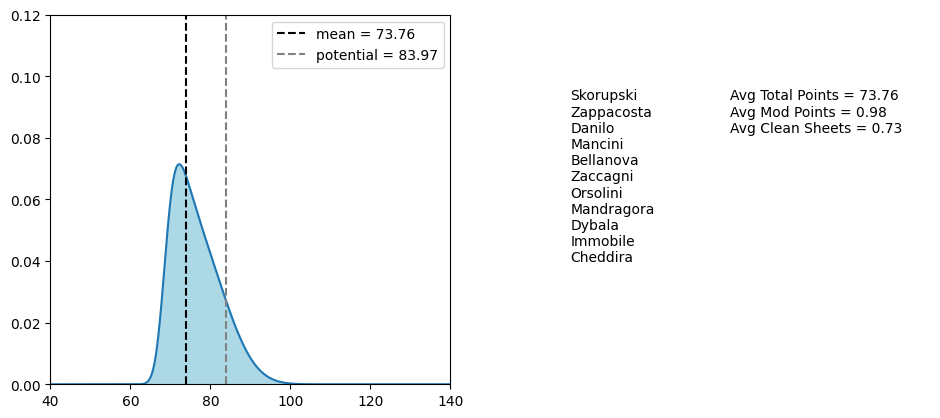

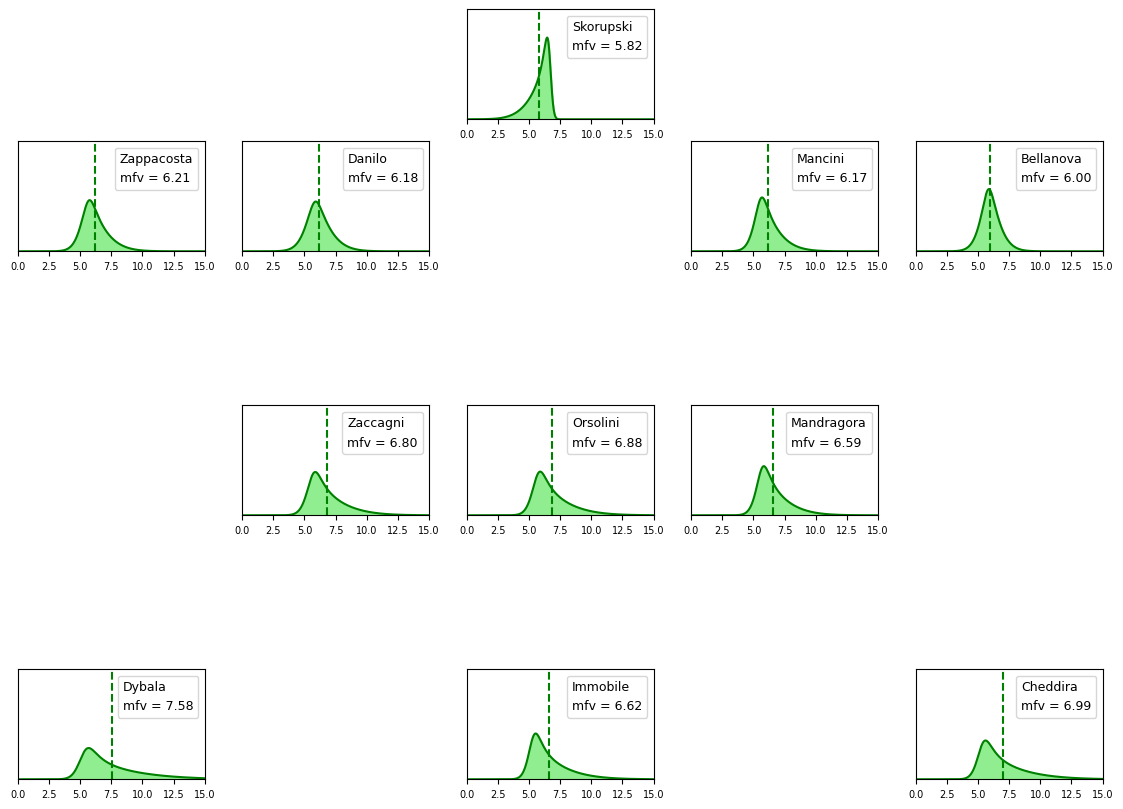

In [ ]:
squad = ['Skorupski',
        'Zappacosta',
        'Danilo',
        'Mancini',
        'Bellanova',
        'Zaccagni',
        'Orsolini',
        'Mandragora',
        'Dybala',
        'Immobile',
        'Cheddira']

s = simulate_lineup(squad, MOD = True, CS = True)

plot_lineup(squad, config_433_classic)

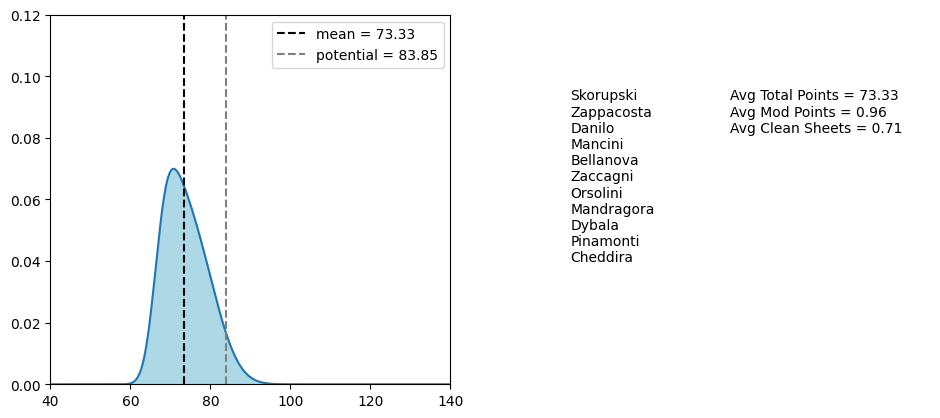

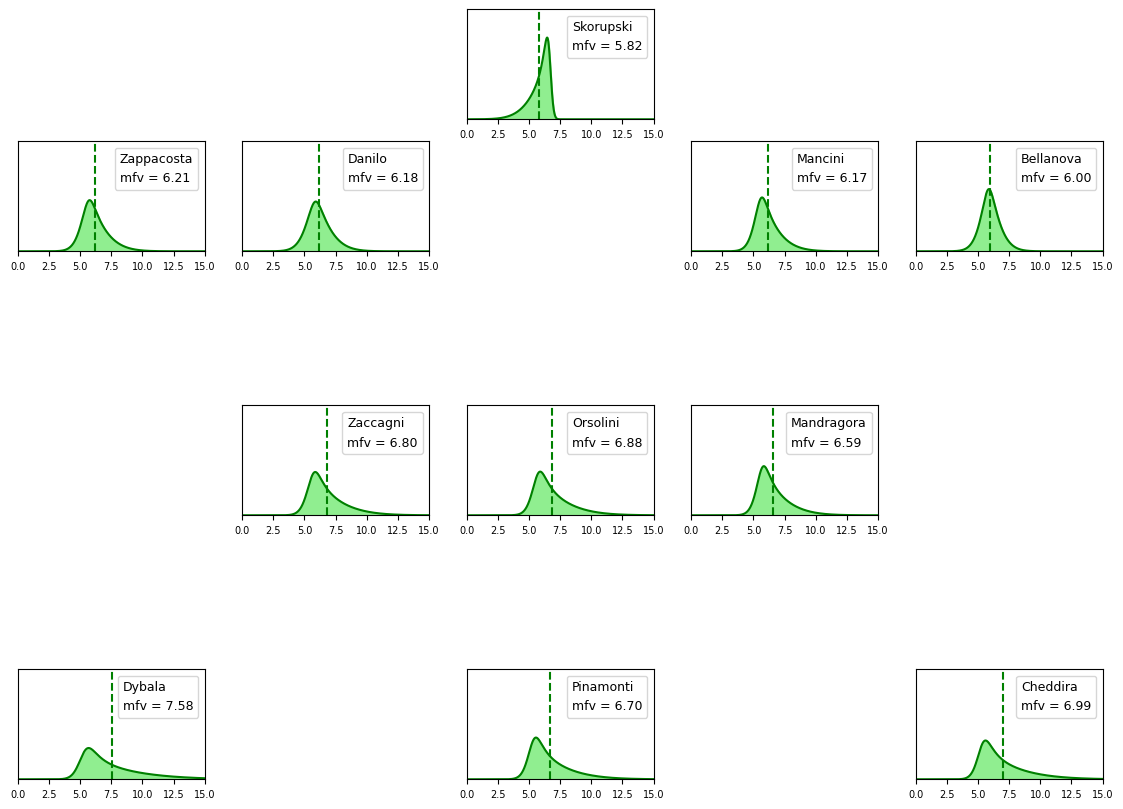

In [ ]:
squad = ['Skorupski',
        'Zappacosta',
        'Danilo',
        'Mancini',
        'Bellanova',
        'Zaccagni',
        'Orsolini',
        'Mandragora',
        'Dybala',
        'Pinamonti',
        'Cheddira']

s = simulate_lineup(squad, MOD = True, CS = True)

plot_lineup(squad, config_433_classic)

In [48]:
from itertools import combinations, product

P = ['Maignan', 'Skorupski', 'Sportiello']
D = ['Bellanova', 'Birindelli', 'Bradaric', 'Danilo', 'Mancini', 'Oyono', 'Posch', 'Zappacosta']
C = ['Baldanzi', 'Ikone', 'Lovric', 'Mandragora', 'Ndoye', 'Orsolini', 'Weah', 'Zaccagni']
A = ['Cheddira', 'Dybala', 'Immobile', 'Milik', 'Petagna', 'Pinamonti']

lineup_configs = ['352', '343', '451', '442', '433', '532', '541']

def extract_players(lineup_config):
    n_defenders = int(lineup_config[0])
    n_midfielders = int(lineup_config[1])
    n_attackers = int(lineup_config[2])

    return n_defenders, n_midfielders, n_attackers

def combine_lineups(lineup_config, P, D, C, A):
    n_def, n_mid, n_att = extract_players(lineup_config)

    def_comb = list(combinations(D, n_def))
    mid_comb = list(combinations(C, n_mid))
    att_comb = list(combinations(A, n_att))

    complete_lineups = list(product(P, def_comb, mid_comb, att_comb))
    print(complete_lineups)


combine_lineups(lineup_configs[0], P, D, C, A)